<a href="https://colab.research.google.com/github/Kolo-Naukowe-Axion/QC1/blob/karinaleskiewicz06-patch-1/model_odra_adapted_ansatz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Quantum Classifier

In [2]:
%pip install qiskit qiskit_machine_learning
%pip install ucimlrepo
%pip install torch
%pip install matplotlib


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [42]:
from qiskit import QuantumCircuit
from qiskit import transpile
from qiskit.circuit import ParameterVector
from qiskit.primitives import StatevectorEstimator, PrimitiveResult, PubResult
from qiskit.primitives.base import BaseEstimatorV2
from qiskit.primitives.containers.data_bin import DataBin
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.gradients import ParamShiftEstimatorGradient
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import EstimatorQNN
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset


import sys          # Standard library module for system-specific parameters and functions
import subprocess   # Standard library module for spawning new processes
from sklearn.preprocessing import MinMaxScaler # Importuje MinMaxScaler do skalowania danych
from sklearn.model_selection import train_test_split # Importuje train_test_split do podziału danych
from ucimlrepo import fetch_ucirepo     # Importuje fetch_ucirepo do pobierania zestawów danych z UCI ML Repository
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score


In [43]:
def ensure_package(pkg_name, import_name=None):
    import_name = import_name or pkg_name
    try:
        __import__(import_name)
    except ImportError:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg_name])

# Ensure all requirements are met
ensure_package('numpy')
ensure_package('scikit-learn', 'sklearn')
ensure_package('ucimlrepo')
ensure_package('qiskit')

def prepare_data():
    """
    Fetches the banknote authentication dataset and returns scaled train/test splits.
    Features are scaled to [0, pi] specifically for Angle Encoding.
    """
    banknote_authentication = fetch_ucirepo(id=267)
    X = banknote_authentication.data.features.to_numpy()
    y = banknote_authentication.data.targets.to_numpy().ravel()

    variance = X[:, 0].reshape(-1, 1)
    skewness = X[:, 1].reshape(-1, 1)

    interaction = skewness * variance
    X_expanded = np.hstack((X, interaction))

    X_train, X_test, y_train, y_test = train_test_split(X_expanded, y, test_size=0.2, random_state=42)

    scaler = MinMaxScaler(feature_range=(0, np.pi))
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test


# Global availability of data
X_tr, X_te, y_tr, y_te = prepare_data()

In [44]:
def ansatz(n_qubits, depth):
    """
    Constructs a hardware-efficient ansatz tailored for a star topology.S
    QB3 (index 2) acts as the central hub for entanglement to avoid SWAP gates.
    Native CZ gates are used to minimize decomposition errors.
    """

    # Each full iteration (2 layers) consumes:
    # Layer 1: n_qubits (RY) + 4 (RZ before CZ) = 9 parameters
    # Layer 2: n_qubits (RX) + 4 (RY before CZ) = 9 parameters
    # Total = 18 parameters per iteration (where depth // 2 is the number of iterations)
    params_per_iter = 18
    total_params = params_per_iter * (depth // 2)
    theta = ParameterVector('θ', total_params)

    qc = QuantumCircuit(n_qubits)

    # The loop iterates (depth // 2) times to execute two-layer blocks.
    for j in range(depth // 2):
        offset = j * params_per_iter

        # -------- Layer 1: RY + Star CZ (RZ-based) --------

        # Sub-layer: Independent RY rotations on all qubits
        for i in range(n_qubits):
            qc.ry(theta[offset + i], i)

        # Sub-layer: Entanglement using Star Topology
        # QB3 (index 2) is the central qubit. We connect it to [0, 1, 3, 4].
        # RZ rotations are added to maintain expressibility while using native CZ.
        target_qubits = [0, 1, 3, 4]
        for idx, target in enumerate(target_qubits):
            # Using parameters offset+5 to offset+8
            qc.rz(theta[offset + n_qubits + idx], target)
            qc.cz(2, target)

        # -------- Layer 2: RX + Star CZ (RY-based) --------

        # Move the offset forward for the second layer within the same iteration
        offset_layer2 = offset + 9

        # Sub-layer: Independent RX rotations on all qubits
        for i in range(n_qubits):
            qc.rx(theta[offset_layer2 + i], i)

        # Sub-layer: Entanglement using Star Topology
        # RY rotations are used here to simulate the effect of a CRY-like interaction.
        for idx, target in enumerate(target_qubits):
            # Using parameters offset_layer2+5 to offset_layer2+8
            qc.ry(theta[offset_layer2 + n_qubits + idx], target)
            qc.cz(2, target)

    return qc

In [45]:
ma=ansatz(5,2)
ma.draw(style="mpl")

┌──────────┐┌──────────┐   ┌──────────┐┌───────────┐             »
q_0: ┤ Ry(θ[0]) ├┤ Rz(θ[5]) ├─■─┤ Rx(θ[9]) ├┤ Ry(θ[14]) ├─────────────»
     ├──────────┤├──────────┤ │ └──────────┘├───────────┤┌───────────┐»
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[6]) ├─┼──────■──────┤ Rx(θ[10]) ├┤ Ry(θ[15]) ├»
     ├──────────┤└──────────┘ │      │      └───────────┘└───────────┘»
q_2: ┤ Ry(θ[2]) ├─────────────■──────■────────────■────────────■──────»
     ├──────────┤┌──────────┐                     │            │      »
q_3: ┤ Ry(θ[3]) ├┤ Rz(θ[7]) ├─────────────────────■────────────┼──────»
     ├──────────┤├──────────┤                                  │      »
q_4: ┤ Ry(θ[4]) ├┤ Rz(θ[8]) ├──────────────────────────────────■──────»
     └──────────┘└──────────┘                                         »
«                                        
«q_0: ───────────────────■───────────────
«                        │               
«q_1: ───────────────────┼───────■───────
«     ┌───────────┐      │       │       
«q_2: ┤ Rx(θ[11]) ├──────■───────■──■──■─
«     ├───────────┤┌───────────┐    │  │ 
«q_3: ┤ Rx(θ[12]) ├┤ Ry(θ[16]) ├────■──┼─
«     ├───────────┤├───────────┤       │ 
«q_4: ┤ Rx(θ[13]) ├┤ Ry(θ[17]) ├───────■─
«     └───────────┘└───────────┘

In [46]:
class SimpleIQMJob:
    """A dummy job that simply holds the result."""
    def __init__(self, result):
        self._result = result
    
    def result(self):
        return self._result

# --- THE BRIDGE CLASS ---
class IQMBackendEstimator(BaseEstimatorV2):
    def __init__(self, backend, options=None):
        super().__init__()
        self._backend = backend
        self._options = options or {"shots": 100}
        # collecting timestamps
        self.timestamp_history = []
        self.total_qpu_time = 0.0  # Sum of time on quantum

    def _extract_timestamps(self, result):
        try:
            timeline = result._metadata.get('timeline', [])
            if not timeline:
                return None
            
            timestamps = {}
            for entry in timeline:
                timestamps[entry.status] = entry.timestamp
            
            return timestamps
        except Exception:
            return None

    def run(self, pubs, precision=None):
        if not isinstance(pubs, list): pubs = [pubs]
        job_results = []
        
        # 1. Prepare Circuit
        base_circuit = pubs[0][0]
        circuit_with_meas = base_circuit.copy()
        if circuit_with_meas.num_clbits == 0:
            circuit_with_meas.measure_all()
        
        # 2. Transpile
        transpiled_qc = transpile(circuit_with_meas, self._backend, optimization_level=3)
        
        for pub in pubs:
            _, observables, parameter_values = pub
            if parameter_values.ndim == 1:
                parameter_values = [parameter_values]
            
            pub_expectations = []
            
            for params in parameter_values:
                bound_qc = transpiled_qc.assign_parameters(params)
                
                # 3. Execute on Hardware
                try:
                    job = self._backend.run(bound_qc, shots=self._options["shots"])
                    result = job.result()
                    
                    # ========== TIMESTAMPS (IQM timeline) ==========
                    ts = self._extract_timestamps(result)
                    if ts:
                        exec_start = ts.get('execution_started')
                        exec_end = ts.get('execution_ended')
                        comp_start = ts.get('compilation_started')
                        comp_end = ts.get('compilation_ended')
                        job_created = ts.get('created')
                        job_completed = ts.get('completed')
                        
                        if exec_start and exec_end:
                            execution_time = (exec_end - exec_start).total_seconds()
                            compile_time = (comp_end - comp_start).total_seconds() if comp_start and comp_end else 0
                            job_time = (job_completed - job_created).total_seconds() if job_created and job_completed else 0
                            
                            self.timestamp_history.append({
                                'execution_time_qpu': execution_time,
                                'job_time_total': job_time,
                                'compile_time': compile_time,
                                'raw_timestamps': ts
                            })
                            self.total_qpu_time += execution_time
                            
                            print(f"TIME ON QPU: {execution_time*1000:.2f}ms | "
                                  f"Compilation: {compile_time*1000:.2f}ms | "
                                  f"Job overall: {job_time:.3f}s")
                    # =========================================================
                    
                    counts = result.get_counts()
                    
                    if isinstance(counts, list): counts = counts[0]

                    # 4. Calculate Expectation
                    shots = sum(counts.values())
                    count_0 = 0
                    for bitstring, count in counts.items():
                        if bitstring[-1] == '0':
                            count_0 += count
                    
                    p0 = count_0 / shots
                    p1 = 1 - p0
                    pub_expectations.append(p0 - p1)

                except Exception as e:
                    print(f"Job failed: {e}")
                    pub_expectations.append(0.0)
            
            data = DataBin(evs=np.array(pub_expectations), shape=(len(pub_expectations),))
            job_results.append(PubResult(data=data))

        return SimpleIQMJob(PrimitiveResult(job_results))
    
    def print_timing_summary(self):
        """Detailed summary."""
        if not self.timestamp_history:
            print("Brak danych o timestampach.")
            return
        
        print("\n" + "="*60)
        print("DETAILED SUMMARY OF THE TIMESTAMPS")
        print("="*60)
        print(f"Number of executed jobs: {len(self.timestamp_history)}")
        
        qpu_times = []
        compile_times = []
        queue_times = []
        network_times = []
        
        for t in self.timestamp_history:
            ts = t['raw_timestamps']
            
            # QPU
            if ts.get('execution_started') and ts.get('execution_ended'):
                qpu_times.append((ts['execution_ended'] - ts['execution_started']).total_seconds())
            
            # Compilation
            if ts.get('compilation_started') and ts.get('compilation_ended'):
                compile_times.append((ts['compilation_ended'] - ts['compilation_started']).total_seconds())
            
            # Queue (waiting for QPU)
            if ts.get('pending_execution') and ts.get('execution_started'):
                queue_times.append((ts['execution_started'] - ts['pending_execution']).total_seconds())
            
            # (created->received + ready->completed)
            net_time = 0
            if ts.get('created') and ts.get('received'):
                net_time += (ts['received'] - ts['created']).total_seconds()
            if ts.get('ready') and ts.get('completed'):
                net_time += (ts['completed'] - ts['ready']).total_seconds()
            network_times.append(net_time)
        
        print(f"\nTIME ON QPU :     {sum(qpu_times)*1000:8.2f} ms  (mean: {np.mean(qpu_times)*1000:.2f} ms/job)")
        print(f"Compilation :           {sum(compile_times)*1000:8.2f} ms  (mean: {np.mean(compile_times)*1000:.2f} ms/job)")
        print(f"Queue (wait QPU) :   {sum(queue_times)*1000:8.2f} ms  (mean: {np.mean(queue_times)*1000:.2f} ms/job)")
        print(f"(upload+down) :   {sum(network_times)*1000:8.2f} ms  (mean: {np.mean(network_times)*1000:.2f} ms/job)")
        
        total_measured = sum(qpu_times) + sum(compile_times) + sum(queue_times) + sum(network_times)
        total_job = sum(t['job_time_total'] for t in self.timestamp_history)
        other = total_job - total_measured
        
        print(f"Others (validation etc): {other*1000:8.2f} ms")
        print(f"\nTIME OVERALL:       {total_job*1000:8.2f} ms ({total_job:.3f} s)")
        
        print("\n" + "-"*40)
        print("PERCENTAGE DISTRIBUTION: ")
        print(f"  QPU:        {100*sum(qpu_times)/total_job:5.1f}%")
        print(f"  Compilation: {100*sum(compile_times)/total_job:5.1f}%")
        print(f"  Queue:    {100*sum(queue_times)/total_job:5.1f}%")
        print(f"  Network:       {100*sum(network_times)/total_job:5.1f}%")
        print(f"  Others:       {100*other/total_job:5.1f}%")
        print("="*60 + "\n")

In [54]:
"""
    The code below constructs the class HybridModel. It is built using the Qiskit and Pytorch library and
    and utilizes its built-in tools, to create a model connecting classical and quantum computing.

"""

class HybridModel(nn.Module):
    def __init__(self, ansatz_circuit, num_qubits):
        super().__init__()
        self.feature_map = self.angle_encoding(num_qubits)

        # Connecting the quantum circuit. Connecting our feature map (data) and ansatz
        self.qc = QuantumCircuit(num_qubits)
        self.qc.compose(self.feature_map, qubits=range(num_qubits), inplace=True)
        self.qc.compose(ansatz_circuit, inplace=True)

        # Firstly, we inicialize parameters. Our quantum model cannot tell whether the number came from ansatz or feature.
        # That is why here we sort them into two lists. If the number came from feature_map, then it will be a feature and the other way around.
        input_params = list(self.feature_map.parameters)
        weight_params = list(ansatz_circuit.parameters)

        '''
        Measure the Z-operator (spin) on the very first qubit (q_0) and ignore all the other qubits.
        Qiskit reads the string in a reversed order, that is why the Z gate is on the end.
        SparsePauliOp.from_list([("I" * (num_qubits - 1) + "Z", 1)]) converts string into a mathematical matrix that Qiskit can use for calculations
        Coefficient = 1 is a weight we multiply our result by. In QML it is mostly set to 1
        '''

        observable = SparsePauliOp.from_list([("I" * (num_qubits - 1) + "Z", 1)])

        # Estimator takes ansatz, observables and parameters (data and weights), returns the Expectation value.
        # !!!! CHANGE WHEN USING ON QUANTUM COMPUTER
        # Needed when running quantum simulations, it should be changed when implementing on real quantum computer
        estimator = StatevectorEstimator()

        # Compute the gradients of the sampling probability by the Parameter Shift Rule.
        gradient = ParamShiftEstimatorGradient(estimator)


        '''
        The EstimatorQNN
        This class from Qiskit Machine Learning is used to instantiate the quantum neural network.
        It leverages the Qiskit Primitives (Estimator) to efficiently calculate expectation values
        of the quantum circuit. This allows the model to output continuous, differentiable values (gradients)
        required for backpropagation in hybrid quantum-classical training.
        '''

        self.qnn = EstimatorQNN(
            circuit=self.qc,
            observables=observable,
            input_params=input_params,
            weight_params=weight_params,
            estimator=estimator,
            gradient=gradient
        )

        '''
        TORCH CONNECTOR
        This line initializes the TorchConnector, which serves as a bridge between Qiskit and PyTorch. It wraps the Quantum Neural Network (QNN)
        to make it function as a standard, differentiable PyTorch module (nn.Module).
        This integration allows the quantum parameters to be optimized using standard PyTorch tools like
        the Adam optimizer and automatic differentiation.
        '''
        self.quantum_layer = TorchConnector(self.qnn)

        """
        Creates a Feature Map circuit using Angle Encoding. It maps classical input vectors
        to the quantum space by applying Ry(theta) rotations on each qubit,
        where the rotation angle theta corresponds to the input feature value.
        This effectively encodes the data into the amplitudes of the quantum state
        """

    def angle_encoding(self, num_qubits):
        qc_data = QuantumCircuit(num_qubits)
        input_params = ParameterVector('x', num_qubits)
        for i in range(num_qubits):
            qc_data.ry(input_params[i], i)
        return qc_data

    '''
    This function acts as the main execution path. When the model receives data,
    the forward function passes it into the quantum layer to be processed.
    The quantum layer calculates the result based on the current circuit parameters and returns the prediction.
    '''
    def forward(self, x):
        return self.quantum_layer(x)

In [48]:
EPOCHS = 30
BATCH_SIZE = 16
LEARNING_RATE = 0.01

train_loss_history = []
test_loss_history = []
acc_history = []

print("Loading data...")

X_train, X_test, y_train_raw, y_test_raw = prepare_data()

y_train = 2 * y_train_raw - 1
y_test = 2 * y_test_raw - 1

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

print(f"Data ready. Number of training samples: {len(X_train)}")

Loading data...
Data ready. Number of training samples: 1097


In [49]:
# --- Preparing the DataLoader ---

# Data conversion to tensors for PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

# Creating a dataset with X_train_tensor and Y_train_tensor
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Creating a DataLoader, which now automatically handles shuffle in the training loop
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)



In [ ]:
# Defining a loss function
loss_function = torch.nn.MSELoss()

num_qubits = 5

# Initializing the model with 5 qubits
final_ansatz = ansatz(num_qubits, 2)
model = HybridModel(final_ansatz, num_qubits)

# Initializing the ADAM optimizer
# Now that Our HybridModel is written in Pytorch, optimizer can access the paramiters directly
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"Starting training... Epochs: {EPOCHS}")

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0.0
    batches_count = 0

    for X_batch, y_batch in train_loader:

        optimizer.zero_grad()           # Reset gradients
        output = model(X_batch)         # Forward
        loss = loss_function(output, y_batch) # Loss
        loss.backward()                 # Backward
        optimizer.step()                # Update weights

        epoch_loss += loss.item()
        batches_count += 1

    # Evaluation on tensors
    with torch.no_grad(): # To test our model we turn off the gradients

        test_outputs = model(X_test_tensor)
        test_loss = loss_function(test_outputs, y_test_tensor).item()

        # Calculating accuracy:
        # test.outputs > 0 returns True or False, by using float() we convert bools to 1.0 and 0.0
        # Then, multiply it by two, so for True = 2.0 False = 0.0
        # Substract 1 and the labels are either 1.0 or -1.0
        predicted = (test_outputs > 0).float() * 2 - 1
        correct = (predicted == y_test_tensor).sum().item()
        test_accuracy = correct / len(y_test_tensor)

    avg_loss = epoch_loss / batches_count
    train_loss_history.append(avg_loss)
    test_loss_history.append(test_loss)
    acc_history.append(test_accuracy)

    print(f"Epoch {epoch+1}/{EPOCHS} | Avg loss: {avg_loss:.4f} | Test Acc: {test_accuracy:.4f}")

torch.save(model.state_dict(), "quantum_star_weights.pth")
print(f"Weights saved to: quantum_weights.pth")

Starting training... Epochs: 30
Epoch 1/30 | Avg loss: 0.7647 | Test Acc: 0.7455


In [50]:
num_qubits = 5

# Initializing the model with 5 qubits
final_ansatz = ansatz(num_qubits, 2)
model = HybridModel(final_ansatz, num_qubits)

try:
    model.load_state_dict(torch.load("quantum_star_weights.pth"))
    model.eval()
    print("Weights loaded successfully! You can now proceed to hardware testing.")
except FileNotFoundError:
    print("Error: The weights file was not found. Did you save it?")

Weights loaded successfully! You can now proceed to hardware testing.


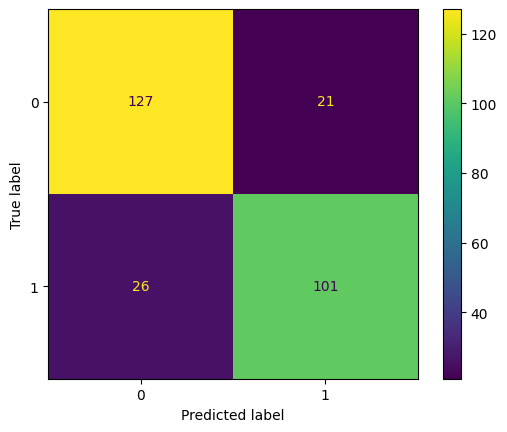

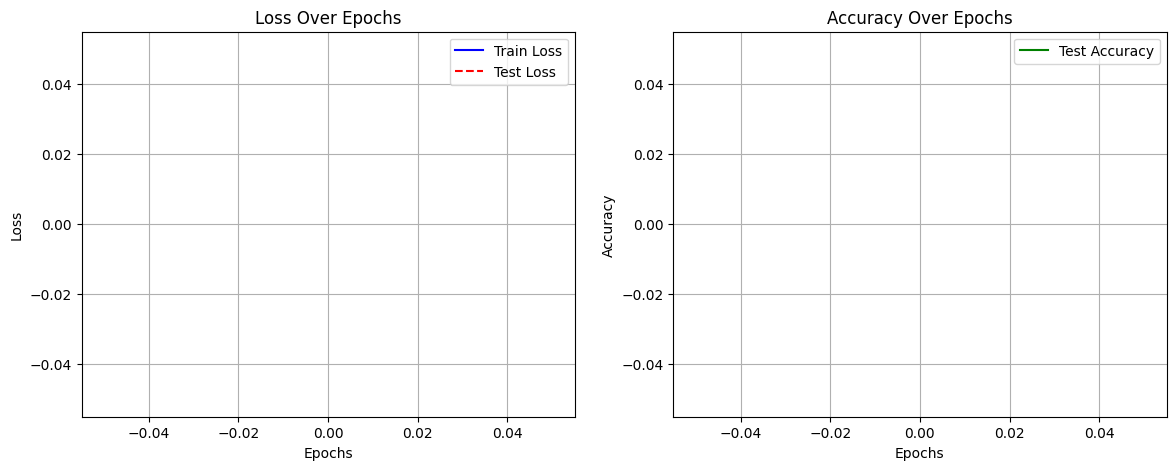

F1 SCORE:  0.8112449799196787  | ACCURACY SCORE:  0.8290909090909091


In [51]:
# @title
with torch.no_grad():
    test_outputs_tensor = model(X_test_tensor)
    test_outputs = test_outputs_tensor.numpy()

predicted = np.where(test_outputs > 0, 1, -1).flatten()

c_matrix_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, predicted))
c_matrix_display.plot()

epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(14, 5))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, label='Train Loss', color='blue')
plt.plot(epochs, test_loss_history, label='Test Loss', color='red', linestyle='--')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, acc_history, label='Test Accuracy', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

print("F1 SCORE: ", f1_score(y_test, predicted), " | ACCURACY SCORE: ", accuracy_score(y_test, predicted))

In [40]:
from iqm.qiskit_iqm import IQMProvider
# ---------------------------------------------------------
# 2. Connect to IQM
# ---------------------------------------------------------
try:
    # Replace URL/Token as needed
    provider = IQMProvider("https://odra5.e-science.pl/", token=input("Enter IQM Token: "))
    iqm_backend = provider.get_backend()
    print(f"Connected to backend: {iqm_backend.name}")
except Exception as e:
    print(f"Connection error: {e}")
    # Stop execution if connection fails (optional safety)
    exit()

# ---------------------------------------------------------
# 3. Instantiate the Bridge & QNN
# ---------------------------------------------------------

# Create the hardware estimator
hardware_estimator = IQMBackendEstimator(iqm_backend, options={"shots": 100})

print("Building Hardware QNN for 5 Qubits...")

# CONFIGURATION
N_QUBITS = 5
DEPTH = 2  # Must be divisible by 2 based on your ansatz logic

# Build Circuit Components
hw_ansatz = ansatz(N_QUBITS, DEPTH)

# NOTE: Ensure your 'model' object can generate a 5-qubit encoding.
# If 'model.angle_encoding' is hardcoded to 4, you must update it.
hw_feature_map = model.angle_encoding(N_QUBITS) 

hw_qc = QuantumCircuit(N_QUBITS)
hw_qc.compose(hw_feature_map, qubits=range(N_QUBITS), inplace=True)
hw_qc.compose(hw_ansatz, inplace=True)

# Observable for 5 Qubits
# "IIIIZ" measures Qubit 0 (Qiskit is little-endian: q4, q3, q2, q1, q0)
# If you want to measure the Central Qubit (Q2), use "IIZII"
observable = SparsePauliOp.from_list([("I" * (N_QUBITS - 1) + "Z", 1)])

# Create QNN with the HARDWARE ESTIMATOR
hw_qnn = EstimatorQNN(
    circuit=hw_qc,
    observables=observable,
    input_params=list(hw_feature_map.parameters),
    weight_params=list(hw_ansatz.parameters),
    estimator=hardware_estimator
)

# Create Torch Layer
iqm_model = TorchConnector(hw_qnn)

# ---------------------------------------------------------
# 4. LOAD TRAINED WEIGHTS
# ---------------------------------------------------------
print("Loading weights...")

# CRITICAL CHECK:
# The 'model.quantum_layer' you are loading from MUST have been trained 
# on a 5-qubit circuit with the exact same ansatz structure (18 params).
# If the trained model was 4-qubits, this line will fail with a shape mismatch.
try:
    iqm_model.load_state_dict(model.quantum_layer.state_dict())
    print("Trained weights transferred to IQM model successfully!")
except RuntimeError as e:
    print("\n[!] Weight Loading Error: The shape of the trained weights does not match the hardware model.")
    print("Ensure the model you are loading from was trained with N_QUBITS=5 and the exact same ansatz.")
    print(f"Details: {e}")

Enter IQM Token:  bj1pcqB47xie5LFhrv4q9HybDyPcDGmaNxTSZHD0zgsBnDnAK691ALl/xtxXuEnq


No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


Connected to backend: IQMBackend
Building Hardware QNN for 5 Qubits...
Loading weights...
Trained weights transferred to IQM model successfully!


In [52]:
from qiskit import transpile
import torch

def get_circuit_stats(circuit, backend):
    # Transpile to see how the hardware actually executes it
    t_qc = transpile(circuit, backend, optimization_level=3)
    ops = t_qc.count_ops()
    return {
        'Depth': t_qc.depth(),
        'SWAPs': ops.get('swap', 0),
        'CNOTs/CZs': ops.get('cz', 0) + ops.get('cx', 0)
    }

# --- FIX 1: Access the circuit correctly via .neural_network.circuit ---
# --- FIX 2: Use 'iqm_backend' instead of 'backend' ---
qnn_circuit = iqm_model.neural_network.circuit
stats = get_circuit_stats(qnn_circuit, iqm_backend)

# 2. Select sample
sample_idx = 67
sample_input = X_test_tensor[sample_idx]
actual_label = y_test_tensor[sample_idx].item()

print(f"Sending job to IQM Spark...")

with torch.no_grad():
    prediction = iqm_model(sample_input)

# Logic: If output > 0 class is 1, else -1 (Adjust based on your specific labels)
predicted_label = 1 if prediction.item() > 0 else -1

# --- FINAL COMPARISON TABLE ---
print("\n" + "="*40)
print(f"        HARDWARE PERFORMANCE REPORT")
print("="*40)
print(f"Circuit Depth:      {stats['Depth']}")
print(f"SWAP Gates:         {stats['SWAPs']}  <-- (Target: 0)")
print(f"CZ Gates:           {stats['CNOTs/CZs']}")
print("-" * 40)
print(f"IQM Raw Output:     {prediction.item():.4f}")
print(f"Predicted Class:    {predicted_label}")
print(f"Actual Class:       {int(actual_label)}")
print(f"Confidence Level:   {abs(prediction.item()):.2%}")
print("="*40)

Sending job to IQM Spark...


QiskitMachineLearningError: 'Invalid input dimension! Received torch.Size([5]) and expected input compatible to 4'

In [29]:
hardware_estimator.print_timing_summary()

for i, ts in enumerate(hardware_estimator.timestamp_history):
    print(f"Job {i}: QPU={ts['execution_time_qpu']:.6f}s, Total={ts['job_time_total']:.4f}s")


DETAILED SUMMARY OF THE TIMESTAMPS
Number of executed jobs: 1

 TIME ON QPU:       167.42 ms  (średnio: 167.42 ms/job)
Compilation :              71.01 ms  (średnio: 71.01 ms/job)
Queue (wait QPU):      10.77 ms  (średnio: 10.77 ms/job)
(upload+down):     764.40 ms  (średnio: 764.40 ms/job)
Others (validation etc):  1219.17 ms

 TIME OVERALL:        2232.77 ms (2.233 s)

----------------------------------------
ROZKŁAD PROCENTOWY:
  QPU:          7.5%
  Kompilacja:   3.2%
  Kolejka:      0.5%
  Sieć:        34.2%
  Inne:        54.6%

Job 0: QPU=0.167420s, Total=2.2328s


In [16]:
import time

def evaluate_estimator_sample(model, input_tensor, true_label_tensor):
    model.eval()
    if input_tensor.dim() == 1:
        input_batch = input_tensor.unsqueeze(0)
    else:
        input_batch = input_tensor

    start_time = time.perf_counter()
    
    with torch.no_grad():
        output = model(input_batch)
        
    end_time = time.perf_counter()
    
    time_taken = end_time - start_time
    
    expectation_value = output.item()
    predicted_label = 1.0 if expectation_value > 0 else -1.0
    true_label = true_label_tensor

    return {
        "expectation_value": expectation_value,
        "predicted_label": predicted_label,
        "true_label": true_label,
        "time_seconds": time_taken
    }

In [17]:
results = evaluate_estimator_sample(model, sample_input, actual_label)

# Print the results
print("-" * 30)
print(f"Single Forward Pass (Sample {sample_idx})")
print("-" * 30)
print(f"Expectation Value: {results['expectation_value']:.6f}")
print(f"Predicted Label:   {results['predicted_label']}")
print(f"True Label:        {results['true_label']}")
print(f"Time Taken:        {results['time_seconds']:.10f} sec")
print("-" * 30)

------------------------------
Single Forward Pass (Sample 67)
------------------------------
Expectation Value: -0.411477
Predicted Label:   -1.0
True Label:        -1.0
Time Taken:        0.0151484340 sec
------------------------------
